In [16]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt


In [17]:
# Change this path to where your CSV is located
csv_path = r"C:\Users\ammar\OneDrive\Desktop\Online Sales Data.csv"

# Load CSV
df = pd.read_csv(csv_path, encoding='utf-8')

# Preview first 5 rows
df.head()


,Transaction ID,Date,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal


In [18]:
# Rename columns for SQL
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.rename(columns={
    'transaction_id': 'order_id',
    'date': 'order_date',
    'total_revenue': 'amount'
}, inplace=True)

print(df.columns)


Index(['order_id', 'order_date', 'product_category', 'product_name',
       'units_sold', 'unit_price', 'amount', 'region', 'payment_method'],
      dtype='object')


In [19]:
# Create SQLite database (file will be created in your working folder)
conn = sqlite3.connect("online_sales.db")

# Store the dataframe as a table named 'orders'
df.to_sql("orders", conn, if_exists="replace", index=False)

# Check that table is created by listing all tables
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables in database:", tables)


Tables in database: [('orders',)]


In [20]:
# Fetch first 5 rows from orders table
test_query = "SELECT * FROM orders LIMIT 2;"
pd.read_sql_query(test_query, conn)


,order_id,order_date,product_category,product_name,units_sold,unit_price,amount,region,payment_method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal


In [21]:
query = """
SELECT
    STRFTIME('%Y', order_date) AS year,
    STRFTIME('%m', order_date) AS month,
    SUM(amount) AS monthly_revenue,
    COUNT(DISTINCT order_id) AS order_volume
FROM orders
GROUP BY year, month
ORDER BY year ASC, month ASC;
"""

# Run the query and store results in a DataFrame
sales_trend = pd.read_sql_query(query, conn)
sales_trend


,year,month,monthly_revenue,order_volume
0,2024,01,14548.32,31
1,2024,02,10803.37,29
2,2024,03,12849.24,31
3,2024,04,12451.69,30
4,2024,05,8455.49,31
5,2024,06,7384.55,30
6,2024,07,6797.08,31
7,2024,08,7278.11,27


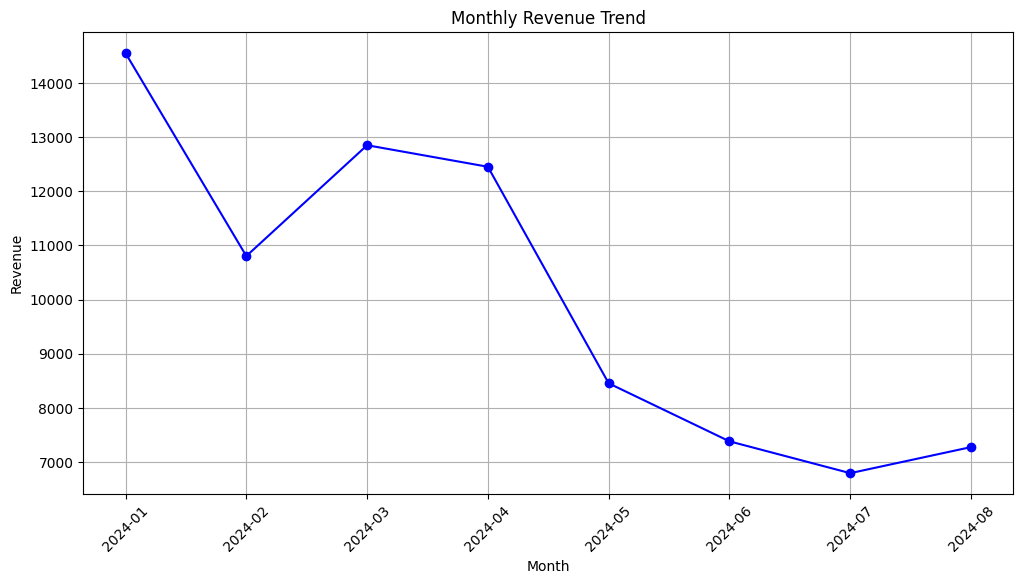

In [24]:
# Combine year and month for x-axis labels
sales_trend['year_month'] = sales_trend['year'] + '-' + sales_trend['month']

# Plot monthly revenue
plt.figure(figsize=(12,6))
plt.plot(sales_trend['year_month'], sales_trend['monthly_revenue'], marker='o', color='blue')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


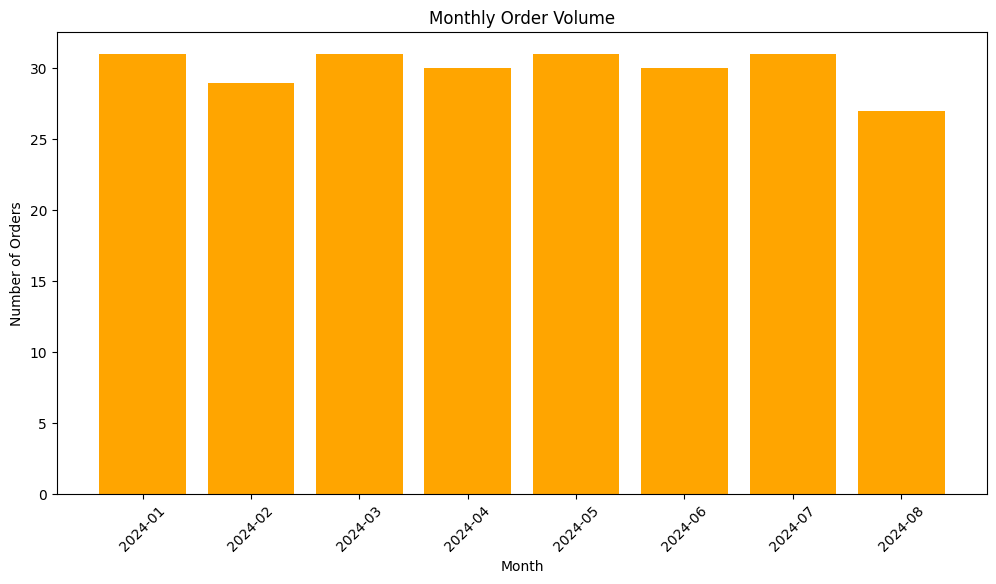

In [25]:
plt.figure(figsize=(12,6))
plt.bar(sales_trend['year_month'], sales_trend['order_volume'], color='orange')
plt.xticks(rotation=45)
plt.title("Monthly Order Volume")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()


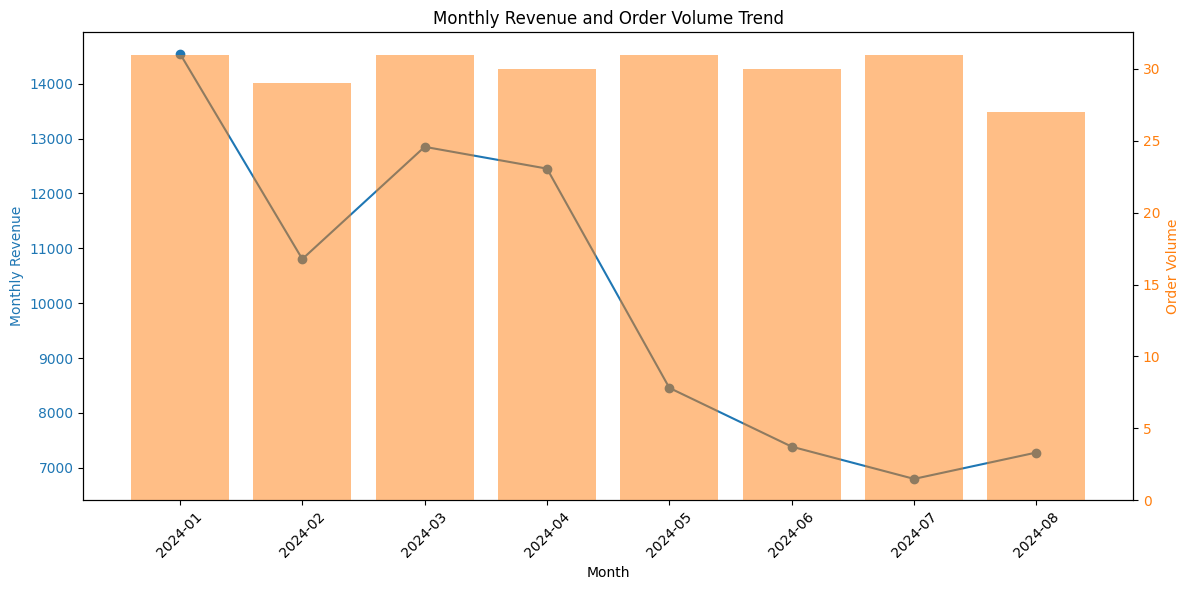

In [26]:
fig, ax1 = plt.subplots(figsize=(12,6))

# X-axis: year-month
x = sales_trend['year_month']

# Left y-axis: Monthly Revenue
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Monthly Revenue', color=color)
ax1.plot(x, sales_trend['monthly_revenue'], color=color, marker='o', label='Revenue')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

# Right y-axis: Order Volume
ax2 = ax1.twinx()  # instantiate a second y-axis
color = 'tab:orange'
ax2.set_ylabel('Order Volume', color=color)
ax2.bar(x, sales_trend['order_volume'], color=color, alpha=0.5, label='Order Volume')
ax2.tick_params(axis='y', labelcolor=color)

# Add title
plt.title('Monthly Revenue and Order Volume Trend')
fig.tight_layout()  # adjusts layout
plt.show()
